# Quiz

Start by taking the second  quiz of the course.

# Stereo camera calibration

This week you'll be provided with a set of stereo images, and your task is to undistort and rectify the images, such that they can be used with the stereo depth reconstruction you made on day 6. You are still not allowed to use opencv functions for block matching/template matching, however you are free to use opencv when undistorting the images. It is recommended that you finish the exercises from Monday before continuing with the weekly project.

The image sets are found in the attached zip-file. Start with the rs.zip and move on to mynteye.zip once you have it working. The physical dimensions of each square of the pattern are 33.6 x 33.6 mm.

Hint: You'll have to undistort the images before rectifying them.

In [3]:
import glob

import cv2
import numpy as np
from matplotlib import pyplot as plt

plt.gray()

SQUARE_SIZE = 33.6  #mm
nb_vertical = 6
nb_horizontal = 7


def calibration(images: list[str]):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((nb_horizontal * nb_vertical, 3), np.float32)
    objp[:, :2] = np.mgrid[0:nb_vertical, 0:nb_horizontal].T.reshape(-1, 2)

    # Arrays to store object points and image points from all the images.
    objpoints = []  # 3d point in real world space
    imgpoints = []  # 2d points in image plane.

    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nb_vertical, nb_horizontal))

        # If found, add object points, image points (after refining them)
        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)
            # Draw and display the corners
            cv2.drawChessboardCorners(img, (nb_vertical, nb_horizontal), corners, ret)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return mtx, dist


def undistorted(images: list[str], mtx, dist):
    undistorted_images = []
    for fname in images:
        img = cv2.imread(fname)
        h, w = img.shape[:2]
        newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))
        dst = cv2.undistort(img, mtx, dist, None, newcameramtx)
        x, y, w, h = roi
        undistorted_images.append(dst[y:y + h, x:x + w])
    return undistorted_images

<Figure size 640x480 with 0 Axes>

In [8]:
import math


def sum_absolute_diff(img1, img2):
    return np.absolute(img1.astype(np.int64) - img2.astype(np.int64)).sum()


def find_max_corr(img, span, corr=sum_absolute_diff):
    assert img.shape[0] == span.shape[0]

    candidate = (0, 1_000_000)

    for i in range(0, span.shape[1] - img.shape[1] + 1):
        span_slice = span[:, i:i + img.shape[1]]
        s = corr(img, span_slice)
        if s < candidate[1]:
            candidate = i, s

    return candidate


def block_matching(gray_left, gray_right, size=7):
    result = np.zeros((math.ceil((gray_left.shape[0] - size) / 7), math.ceil((gray_left.shape[1] - size) / 7), 2),
                      dtype=np.int32)

    for row in range(0, gray_left.shape[0] - size, 7):
        span = gray_right[row:row + size, :]
        for col in range(0, gray_left.shape[1] - size, 7):
            r = find_max_corr(gray_left[row:row + size, col:col + size], span)
            result[row // 7, col // 7, :] = r[0] - col, r[1]

    return result

In [10]:
left_images = glob.glob('rs/left*.png')
right_images = glob.glob('rs/right*.png')
mtx, dist = calibration(left_images + right_images)

left_undistorted_images = undistorted(left_images, mtx, dist)
right_undistorted_images = undistorted(right_images, mtx, dist)

results = []

for gray_left, gray_right in zip(left_undistorted_images, right_undistorted_images):
    results.append(block_matching(gray_left, gray_right))

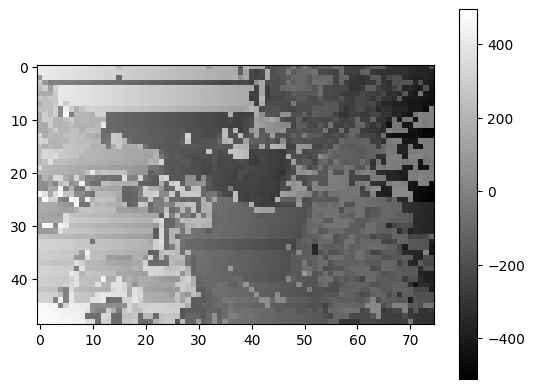

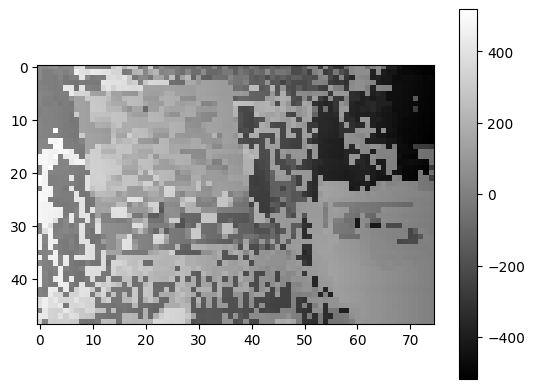

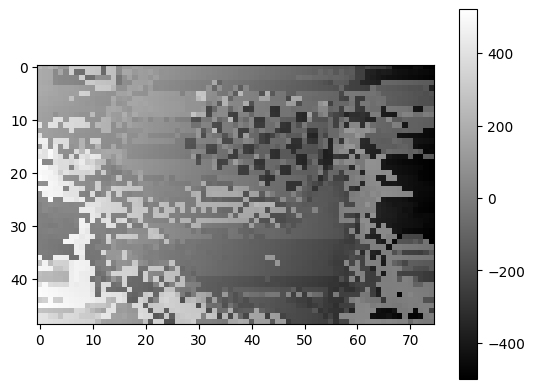

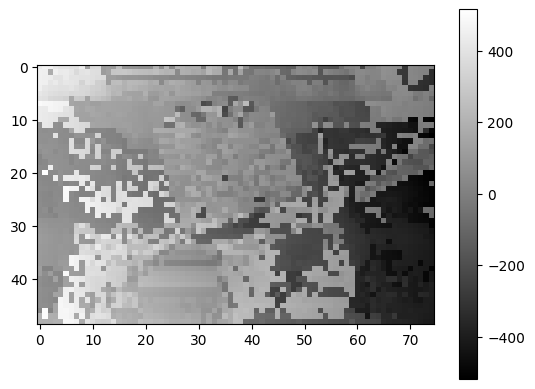

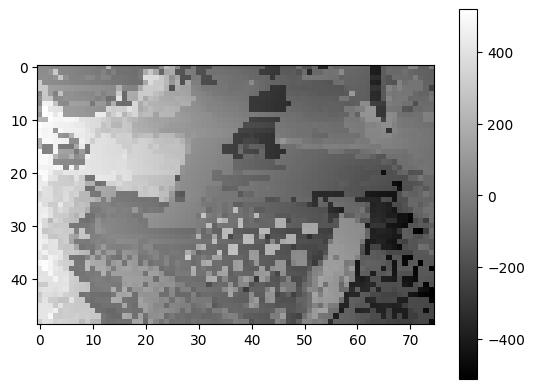

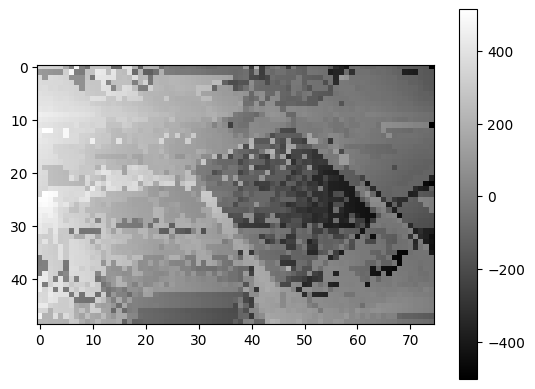

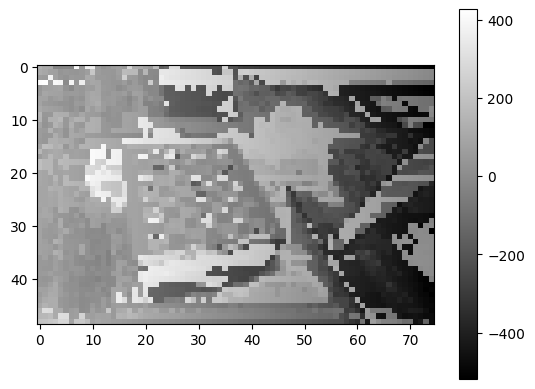

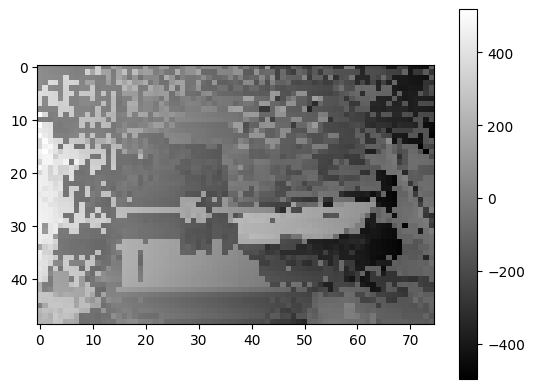

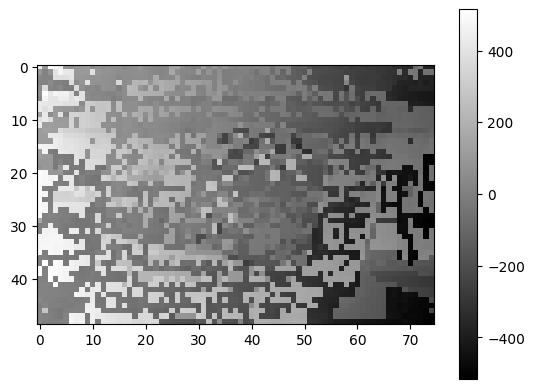

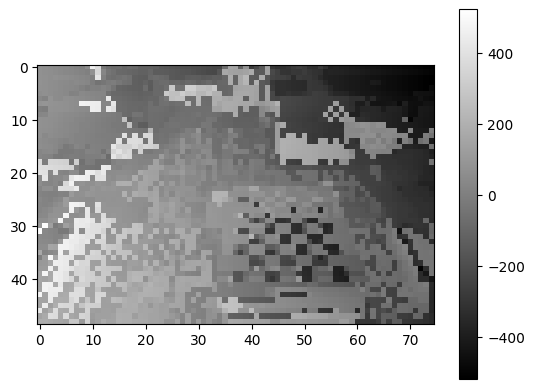

In [12]:
for r in results[:10]:
    plt.imshow(r[:, :, 0])
    plt.colorbar()
    plt.show()